<a href="https://colab.research.google.com/github/Jsevillamol/quantumcomputingtimelines/blob/main/QuantumComputingProgress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown **Double click here to see the code to import required libraries and the dataset**

#@markdown To play around with the graphs, execute the cells in order (ctrl + enter), starting with this one

#@markdown You will be prompted to give your credentials to access the data spreadsheet

#@markdown This notebook includes the code to
#@markdown * Visualize the **contour plot of the generalized logical qubit metric** 
#@markdown * **visualize the data**
#@markdown * perform a **multivariate loglinear regression with bootstrapping** 
#@markdown * perform a **multivariate extrapolation with bootstrapping**
#@markdown * extrapolate via a **geometric drift model** 

#@markdown Double click any cell to see the associated code.


import numpy as np
from scipy import special
from scipy import stats
from scipy import odr
from scipy.stats import multivariate_normal
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math
import pandas as pd
import altair as alt
import collections
from datetime import datetime


from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# worksheet = gc.open('Quantum computing progress').sheet1
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1pwb4gf0FxlxgfVhtXTaqEGS9b7FwsstsJ0v7Zb1naQ0').sheet1
# worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1utGUc1Okg4XfF06Ilhyy0jFLqL9RnbFaVXDynwFjfb8/edit#gid=0').sheet1


# get_all_records gives a dict with the contents of the spreadsheet
rows = worksheet.get_all_records()

# Convert to a DataFrame
df = pd.DataFrame.from_records(rows)

# Fix metric column types
metrics = ["Physical qubits", "Average two-qubit gate error rate"]
for metric in metrics:
  df[metric] = pd.to_numeric(df[metric], errors="coerce")

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Impute missing dates with year when available
df["Date"] = df.apply(lambda row : row["Date"] \
              if row["Date"] is not pd.NaT or pd.isna(row["Year"]) \
              else pd.Timestamp(year=np.int64(row["Year"]), month=6, day=1),
              axis=1)

# (discretization) Rounds dates down to the year
#df["Date"] =  df.apply(lambda row : pd.Timestamp(year=np.int64(row["Date"].year), month=1, day=1) if not pd.isna(row["Date"]) else np.nan, axis=1)

# Substitute year with fractional year, rounded to the month
df["Year"] = df.apply(lambda row : row["Date"].year + row["Date"].month/12, axis=1)

#####################################################################

# define generalized logical qubits metric
def GLQ(physical_qubits, error_rate, target_fidelity=1/5.2e17, threshold_fidelity=1e-2): #  
  if error_rate < target_fidelity: return physical_qubits
  if error_rate > threshold_fidelity: return 0.
  surface_QEC_factor = (4*np.log(np.sqrt(10)* error_rate / target_fidelity)/np.log(threshold_fidelity/error_rate) + 1)**2
  #surface_code_distance = np.log(10*(target_fidelity)**2/error_rate**2)/np.log(100*error_rate)
  #surface_QEC_factor = (2*surface_code_distance+1)**2
  generalized_logical_qubits = physical_qubits / surface_QEC_factor
  return generalized_logical_qubits

vect_GLQ = np.vectorize(GLQ)

# Add GLQs to the df

df["Generalized logical qubits"] = df.apply (lambda row: GLQ(row["Physical qubits"], row["Average two-qubit gate error rate"]), axis=1)

#######################################################################
# show all data
df

,Designation,Source,Link to source,Meta source,Group,Source type,Technology,Date,Year,Physical qubits,Average two-qubit gate error rate,NOTE: Hover over the cells marked with a black triangle for context and quotes,Generalized logical qubits
0,Aspen-7,"""Proveedores de hardware de Amazon Braket""",https://aws.amazon.com/es/braket/hardware-prov...,Quantum Computing Report,Rigetti,Hardware provider information sheet,Superconductor,2019-10-24,2019.833333,32.0,0.04800,,0.000000e+00
1,Yorktown - ibmqx2,(IBM Quantum Computing Experience),https://quantum-computing.ibm.com/,IBM Quantum Experience Available Systems,IBM,Cloud quantum computing service,Superconductor,2019-03-15,2019.250000,5.0,0.03960,,0.000000e+00
2,Melbourne,(IBM Quantum Computing Experience),https://quantum-computing.ibm.com/,IBM Quantum Experience Available Systems,IBM,Cloud quantum computing service,Superconductor,2018-12-21,2019.000000,15.0,0.05450,,0.000000e+00
3,Vigo,(IBM Quantum Computing Experience),https://quantum-computing.ibm.com/,IBM Quantum Experience Available Systems,IBM,Cloud quantum computing service,Superconductor,2019-02-08,2019.166667,5.0,0.00966,,2.685790e-07
4,Ourense,(IBM Quantum Computing Experience),https://quantum-computing.ibm.com/,IBM Quantum Experience Available Systems,IBM,Cloud quantum computing service,Superconductor,2019-02-08,2019.166667,5.0,0.00909,,2.048267e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Aspen-4,,https://quantumcomputingreport.com/scorecards/...,Quantum Computing Report,Rigetti,[NEED BETTER SOURCE],Superconductor,2019-05-30,2019.416667,16.0,0.09650,,0.000000e+00
61,Cambridge,,https://quantum-computing.ibm.com/docs/cloud/b...,IBM Quantum Experience Available Systems,IBM,[COMING SOON],Superconductor,NaT,NaN,28.0,NaN,,NaN
62,Aspen-1,,[UNKNOWN],Quantum Computing Report,Rigetti,[NEED BETTER SOURCE],Superconductor,NaT,NaN,16.0,NaN,,NaN
63,,,,,,,,NaT,NaN,NaN,NaN,,NaN


In [ ]:
#@title GLQ calculator {display-mode: "form", run : "auto"}
log_ph_qubits = 2 #@param {type:"slider", min:0, max:10}
ph_qubits = 10**log_ph_qubits
log_error_rate = -12 #@param {type:"slider", min:-20, max:0}
error_rate = 10**log_error_rate #np.logspace(-20, 0)
glqs = vect_GLQ(ph_qubits, error_rate)
print(f"glqs = {glqs}")

glqs = 69.44444444444444


(1000,)


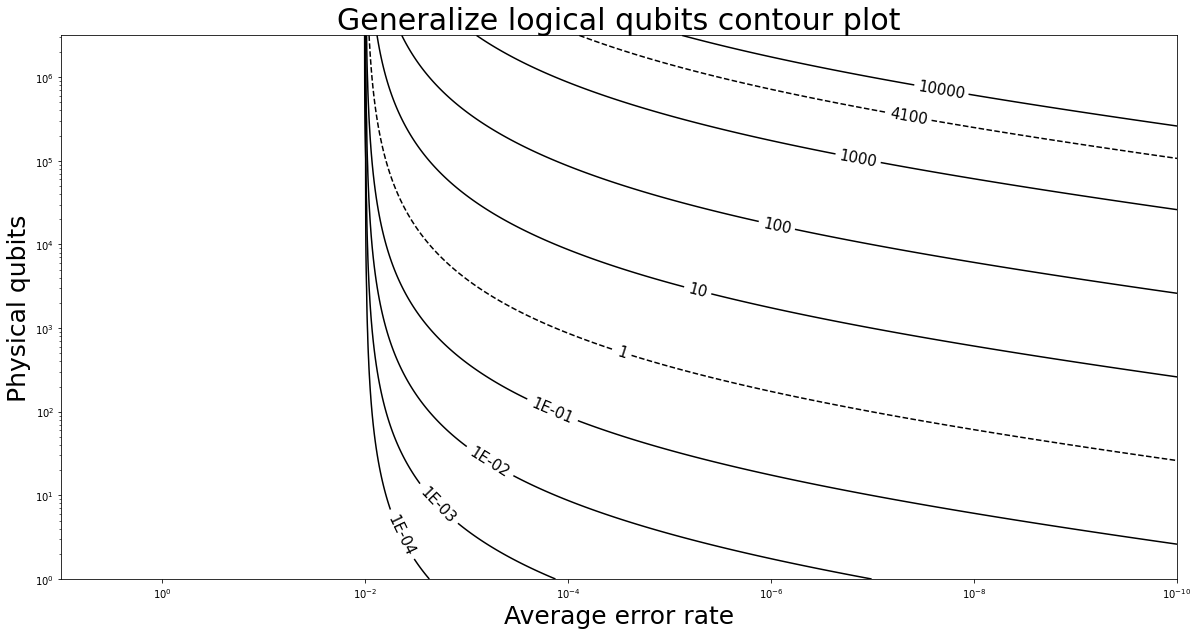

In [ ]:
#@title Generalized logical qubits contour plot

neg_levels = [10**n for n in range(-4,0)] 
pos_levels = [10**n for n in range(1,5)]
thresholds = np.array([1,4100]) 

label_fontsize=15
epsilon = 1e-04
resolution = 1000
error_rates, ph_qubits = np.meshgrid(np.flip(np.logspace(-10,0, resolution)), np.logspace(0., 6.5, resolution)) 
glqs = vect_GLQ(ph_qubits, error_rates)

fig2 = plt.figure(figsize=(20,10))
ax2 = fig2.add_subplot(111)
ax2.set_title("Generalize logical qubits contour plot", fontsize=30)
ax2.set_xlabel("Average error rate", fontsize=25)
ax2.set_ylabel("Physical qubits", fontsize=25)
ax2.set_xscale("log")
ax2.set_xlim(10, 10**-10)
ax2.set_yscale("log")

# Construct a line where to place the contour levels
a=-1 ; b =1e-2*1.5
line_x = np.logspace(-10,0, resolution)
line_y = b*(line_x**a)
line = np.c_[line_x,line_y]
line_glqs = vect_GLQ(line_y,line_x)
print(line_glqs.shape)

# Find the intersection of the line and the contours
neg_manual_label_locations = []
for level in neg_levels:
  idx = np.argmin(np.abs(line_glqs-level))
  neg_manual_label_locations.append((line_x[idx], line_y[idx]))

pos_manual_label_locations = []
for level in pos_levels:
  idx = np.argmin(np.abs(line_glqs-level))
  pos_manual_label_locations.append((line_x[idx], line_y[idx]))

thresholds_manual_label_locations = []
for threshold in thresholds:
  idx = np.argmin(np.abs(line_glqs-threshold))
  thresholds_manual_label_locations.append((line_x[idx], line_y[idx]))

# Draw the GLQ levels < 1
CS = ax2.contour(error_rates, ph_qubits, glqs, levels=neg_levels,colors='black');
# adjusting sig figs: https://stackoverflow.com/questions/55846749/how-to-reduce-decimal-places-in-a-matplotlib-contour-plot
ax2.clabel(CS, inline=1, fontsize=label_fontsize, fmt="%.0E",  manual = neg_manual_label_locations);

# Draw the GLQ levels > 1
CS = ax2.contour(error_rates, ph_qubits, glqs, levels=pos_levels,colors='black');
# adjusting sig figs: https://stackoverflow.com/questions/55846749/how-to-reduce-decimal-places-in-a-matplotlib-contour-plot
ax2.clabel(CS, inline=1, fontsize=label_fontsize, fmt="%1i", manual = pos_manual_label_locations);

# Draw the thresholds
CS2 = ax2.contour(error_rates, ph_qubits, glqs, levels=thresholds, linestyles='dashed', colors='black');

ax2.clabel(CS2, inline=1, fontsize=label_fontsize, fmt="%1i", manual=thresholds_manual_label_locations);

# Data visualization

In [ ]:
#@title Plot key metrics against years {display-mode: "form"}
target = "Physical qubits" #@param ["Physical qubits", "Average two-qubit gate error rate", "Generalized logical qubits"]
data_horizon = [2002, 2022] #@param
data_horizon = [pd.Timestamp(year=x, month=1, day=1) for x in data_horizon]

# Filter the data
df_hat = df.dropna(subset=["Date", target])
df_hat = df_hat[df_hat[target]> 0.]
df_hat = df_hat[data_horizon[0] <= df_hat["Date"]]
df_hat = df_hat[df_hat["Date"] <= data_horizon[1]]



print(f"n = {len(df_hat)}")

# Plot the filtered data
alt.Chart(df_hat,width=1000, height=800
).mark_point(size=200).encode(
  x=alt.X('Date', scale=alt.Scale(), axis = alt.Axis(format = ("%Y"))),
  y=alt.Y(target, scale=alt.Scale(type="log")),
  shape = 'Technology',
  tooltip='Source'
).configure_axis(grid=False,
    labelFontSize=20,
    titleFontSize=40).interactive().configure_legend(
    titleFontSize=20,
    labelFontSize = 18,
    gradientLength=400,
    gradientThickness=30
)

n = 52


alt.Chart(...)

In [ ]:
#@title Plot physical qubits against error rate {display-mode: "form"}
mask = df.notna()["Physical qubits"]
mask &= df.notna()["Average two-qubit gate error rate"]
n = np.sum(mask)
print(f"n={ n }")
alt.Chart(df, width=1000, height=800).mark_point(size=200).encode(
  x=alt.X("Physical qubits", scale=alt.Scale(type="log")),
  y=alt.Y("Average two-qubit gate error rate", scale=alt.Scale(type="log")),
  color = alt.Color("Year:O", 
                    scale=alt.Scale(scheme='viridis')
          ),
  shape = 'Technology'
).configure_axis(grid=False,
    labelFontSize=20,
    titleFontSize=40).interactive().configure_legend(
    titleFontSize=20,
    labelFontSize = 18,
    gradientLength=400,
    gradientThickness=30
)

n=40


alt.Chart(...)

# Extrapolating

In [ ]:
#@title Multivariate loglinear regression with bootstrapping {display-mode: "form"}
# Specify target
print(f"Date of analysis = {datetime.now()}")
data_horizon = (2000, 2016) #@param
data_horizon = [pd.Timestamp(year=x, month=1, day=1) for x in data_horizon]
predict_limit = 2100 #@param {type:"number"}
plot_range = [2000, 2060] #@param
technology_filter = "Superconductor" #@param ["Superconductor", "all"]
print(f"Technology filter = {technology_filter}")

#@markdown Select `take_max` to aggregate the yearly data by a maximum
take_max = True #@param {"type":"boolean"}
print(f"Take max = {take_max}")
#@markdown Select `combined_mode` to make predictions of GLQs based on the extrapolation
#@markdown of physical qubits and gate fidelity. If False, the GLQs are extrapolated on their own.
combined_mode = True #@param {"type" : "boolean"}
print(f"Combined mode = {combined_mode}")
#@markdown The baseline model is the one generated by the whole dataset, no bootstrapping
plot_baseline = False #@param {"type":"boolean"}
plot_bootstrapping = True #@param {"type":"boolean"}

#@markdown Indicate the bootstraped quantile trajectories that will be plotted.
bootstrapping_quantiles = [0.05, 0.5, 0.95] #@param
#@markdown B is the number of resamples taken for bootstrapping
B = 1000 #@param {type:"number"} number of resamples
print(f"Number of bootstraps = {B}")
#@markdown The critical threshold defines the estimator used for bootstrapping,
#@markdown ie the year on which the specified threshold is crossed
critical_threshold =  4100 #@param 
print(f"Critical threshold = {critical_threshold}")

#@markdown Indicate the quantiles of log gaussian noise plotted, approximated via sampling. 
#@markdown If `None` is included, a naive analytical extrapolation is plotted instead.
multivariate_quantiles =  [None]#@param
n_samples = 10000 #@param {"type" : "number"}
if multivariate_quantiles != [None]:
  print(f"n multivariate samples = {n_samples}")
  
glq_thresholds = [1, 4100] #@param

seed = 1111 #@param {type:"number"}
print(f"Seed = {seed}")
np.random.seed(seed) # set seed

##################################################################
# PREPROCESSING

# copy dataframe
df_data = df

# filter by technology
if technology_filter != "all":
  df_data = df_data[df_data["Technology"] == technology_filter]

# drop rows with invalid years
df_data = df_data.dropna(subset=["Date"])

# select time horizon
df_data = df_data[(data_horizon[0] <= df_data["Date"]) & \
                  (df_data["Date"] <= data_horizon[1])]

# Note some characteristics about the data
n = len(df_data)
t0 = df_data["Date"].min()
t1 = df_data["Date"].max()
t = t1 - t0

METRICS = ["Physical qubits", 
           "Average two-qubit gate error rate", 
           "Generalized logical qubits"]

print(f"n = {n}")
print(f"t = {t} years ; [{t0}, {t1}]")

#################################################################################
# PREAMBLE

class SamplingError(Exception):
   """Raised when the input df is not rich enough for inference"""
   pass

def max_aggregation(df_hat, metric):
  """ Delete the entries that do not set new records on the specified metric
  """
  df_hat = df_hat.copy()
  # Temporarily flip the fidelity so the code is equal to the other metrics (max instead of min)
  if metric == "Average two-qubit gate error rate":
    df_hat[metric] = -df_hat[metric].values
  
  mask = df_hat.apply(lambda row : np.all(row[metric] >= df_hat[df_hat["Date"] <= row["Date"]][metric]), axis=1)
  df_hat = df_hat[mask]

  # Undo flipping
  if metric == "Average two-qubit gate error rate":
    df_hat[metric] = -df_hat[metric].values

  return df_hat

class PredictiveModel:
  """
  Class for automatic inference. On initialization takes a dataset, from which 
  a model parameterization is inferred.
  """
  def __init__(self, df_data):
    # Store data
    self.df_data_original = df_data.dropna(subset=["Date"])
    self.df_data = {}
    
    # Parameterize
    self.W = {}
    self.s = {}
    
    self.n = {}

    for metric in METRICS if not combined_mode else METRICS[:2]:
      # Clean data
      df_hat = self.df_data_original.dropna(subset=[metric])
      df_hat = df_hat[df_hat[metric] > 0.]

      # Take max
      if take_max:
        df_hat = max_aggregation(df_hat, metric)

      if len(df_hat) <= 2: raise SamplingError()
      else: 
        self.df_data[metric] = df_hat#.copy()
        self.n[metric] = len(df_hat)

      # Convert to numpy arrays
      x_hat = df_hat["Date"].apply(lambda x: x.year + x.month/12).values
      y_hat = df_hat[metric].values

      # elevate x onto a projective space
      x_hat = np.c_[ np.ones_like(x_hat), x_hat ]

      # take logarithms of data
      y_hat = np.log(y_hat)

      # solve for least squares
      a = np.matmul(x_hat.T, x_hat)
      b = np.matmul(x_hat.T, y_hat)
      W = np.linalg.solve(a,b)
      error = y_hat-np.matmul(x_hat, W)
      s = np.matmul(error.T, error) / (x_hat.shape[0] - x_hat.shape[1])

      # Store parameterization
      self.W[metric] = W
      self.s[metric] = s
    
    # Predict when the critical threshold will be crossed
    x_hat = np.linspace(t0.year, predict_limit, 1000)
    _, _, glqs = self.predict(x_hat)
    t_idx = np.argmin(np.abs(glqs - critical_threshold))
    self.critical_t = x_hat[t_idx]
    
  def predict(self, x_hat, q_sampling=None):
    """
    Make predictions on the values of the three key metrics for each time point in x_hat
    """
    if not combined_mode and q_sampling is None:
      W1 = self.W["Physical qubits"]
      s1 = self.s["Physical qubits"]
      ph_qubits = np.exp(x_hat*W1[1]+W1[0])
      
      W2 = self.W["Average two-qubit gate error rate"]
      s2 = self.s["Average two-qubit gate error rate"]
      fidelities = np.exp(x_hat*W2[1]+W2[0])
      
      W3 = self.W["Generalized logical qubits"]
      s3 = self.s["Generalized logical qubits"]
      glqs = np.exp(x_hat*W3[1]+W3[0])

    elif not combined_mode and q_sampling is not None: # broken
      W1 = self.W["Physical qubits"]
      s1 = self.s["Physical qubits"]
      ph_qubits = np.exp(x_hat*W1[1]+W1[0] + np.sqrt(2*s1)*special.erfinv(2*q_sampling-1))
      
      W2 = self.W["Average two-qubit gate error rate"]
      s2 = self.s["Average two-qubit gate error rate"]
      fidelities = np.exp(x_hat*W2[1]+W2[0]+ np.sqrt(2*s2)*special.erfinv(2*q_sampling-1))
      
      W3 = self.W["Generalized logical qubits"]
      s3 = self.s["Generalized logical qubits"]
      glqs = np.exp(x_hat*W3[1]+W3[0]+ np.sqrt(2*s3)*special.erfinv(2*q_sampling-1))
      
    elif combined_mode and q_sampling is None: 
      W1 = self.W["Physical qubits"]
      ph_qubits = np.exp(x_hat*W1[1]+W1[0])
      W2 = self.W["Average two-qubit gate error rate"]
      fidelities = np.exp(x_hat*W2[1]+W2[0])
      glqs = vect_GLQ(ph_qubits, fidelities)

    else: # combined_mode and q_sampling is not None
      # Sample ph qubits and fidelities
      W1 = self.W["Physical qubits"]
      mu1 = x_hat*W1[1]+W1[0]
      s1 = self.s["Physical qubits"]
      samples1 = np.exp(np.random.normal(mu1, s1, (n_samples, len(x_hat)))).T
      
      W2 = self.W["Average two-qubit gate error rate"]
      mu2 = x_hat*W2[1]+W2[0]
      s2 = self.s["Average two-qubit gate error rate"]
      samples2 = np.exp(np.random.normal(mu2, s2, (n_samples, len(x_hat)))).T

      # Compute glqs
      samples3 = vect_GLQ(samples1, samples2)
      assert samples3.shape == samples1.shape, f"samples3.shape = {samples3.shape}, expected {samples1.shape}"

      # Select desired quantile
      glqs = np.quantile(samples3, q_sampling, axis=1)
      assert glqs.shape == x_hat.shape, f"glqs.shape = {glqs.shape}, expected {x_hat.shape}"

      quantile_idx = np.argmin(np.abs(np.reshape(glqs, (-1,1)) - samples3), axis=1)
      assert quantile_idx.shape == x_hat.shape, f"quantile_idx.shape = {quantile_idx.shape}, expected shape {x_hat.shape}"
      
      ph_qubits = samples1[np.arange(len(samples1)), quantile_idx]
      assert ph_qubits.shape == x_hat.shape, f"ph_qubits.shape = {ph_qubits.shape}, expected {x_hat.shape}"

      fidelities = samples2[np.arange(len(samples2)), quantile_idx]
      assert fidelities.shape == x_hat.shape
      
    return ph_qubits, fidelities, glqs

  def log_residuals(self, x, y, metric):
    ph_qubits, fidelities, glqs = self.predict(x)
    if metric == "Physical qubits":
      y_hat = ph_qubits
    elif metric == "Average two-qubit gate error rate":
      y_hat = fidelities
    elif metric == "Generalized logical qubits":
      y_hat = glqs
    
    log_residuals = np.log(y)-np.log(y_hat)
    return log_residuals

models = {}

#################################################################################
# BASELINE MODEL
if plot_baseline:
  models["Baseline"] = PredictiveModel(df_data)

##########################################################################
# BOOTSTRAPPED MODELS
if plot_bootstrapping:

  model_samples = []
  t_threshold_sample = np.zeros(B)
  retries = 0

  n_sample = {}
  for metric in METRICS if not combined_mode else METRICS[:2]:
    n_sample[metric] = np.zeros(B)

  for idx in range(B):
    while True:
      try:
        df_hat = df_data.sample(n, replace=True)
        model = PredictiveModel(df_hat)
        model_samples.append(model)
        t_threshold_sample[idx] = model.critical_t
        
        for metric in METRICS if not combined_mode else METRICS[:2]:
          n_sample[metric][idx] = model.n[metric]

      except (np.linalg.LinAlgError, SamplingError): 
        retries += 1
        continue
      else: break

  print(f"We needed to repeat {retries} resamples")
  # the bootstrapped critical times should not be always equal
  assert not (t_threshold_sample == t_threshold_sample[0]).all()

  n_trajectories = len(np.unique(t_threshold_sample))
  print(f"There are {n_trajectories} distinct trajectories")

  for metric in METRICS if not combined_mode else METRICS[:2]:
    print(f"The median of {metric.lower()} data points after aggregation was {np.median(n_sample[metric])}")

  # Find the models that correspond to the desired quantiles
  for bootstrap_q in bootstrapping_quantiles:
    threshold = np.quantile(t_threshold_sample,bootstrap_q)
    idx = np.argmin(np.abs(t_threshold_sample - threshold))
    models[f"Bootstrap quantile {bootstrap_q}"] = model_samples[idx]

##########################################################################
# PREDICT TRAJECTORIES FOR EACH MODEL

assert len(models) > 0, "At least one trajectory must be plotted"

x_hat = np.linspace(plot_range[0], plot_range[1], 1000)

predictions = []
data_labels = []

for label, model in models.items():
  
  for multivariate_q in multivariate_quantiles:

    ph_qubits, fidelities, glqs = model.predict(x_hat, multivariate_q)

    label2 = label + (f" multivariate quantile {multivariate_q}" if multivariate_q else '')

    # Compute when we cross each of the thresholds
    for threshold in glq_thresholds:
      if np.any(glqs > threshold):
        idx = np.argmin(np.abs(glqs - threshold))
        t = x_hat[idx]
        print(f"The {threshold} threshold won't be reached until year {t} for {label2}")
      else:
        print(f"The {threshold} threshold won't be reached by year {x_hat.max()} for {label2}")

    model_predictions = [{
        "Model" : label2,
        "Year" : t,
        "Physical qubits" : x1,
        "Average two-qubit gate error rate" : x2,
        "Generalized logical qubits" : x3
    } for t,x1,x2,x3 in zip(x_hat, ph_qubits, fidelities, glqs)]

    predictions += model_predictions
    for metric in METRICS if not combined_mode else METRICS[:2]:
      data = model.df_data[metric]
      data["Model"] = label2
      data["Metric"] = metric
      data_labels.append(data)

predictions_df = pd.DataFrame(predictions)
predictions_df = pd.melt(predictions_df, id_vars=['Year', 'Model'], value_vars=METRICS)

data_labels_df = pd.concat(data_labels)

print("Simulation done!")

Date of analysis = 2020-08-16 09:43:55.495624
Technology filter = Superconductor
Take max = True
Combined mode = True
Number of bootstraps = 1000
Critical threshold = 4100
Seed = 1111
n = 5
t = 2794 days 00:00:00 years ; [2007-08-09 00:00:00, 2015-04-03 00:00:00]


KeyboardInterrupt: ignored

In [ ]:
#@markdown Visualize extrapolation
target = "Generalized logical qubits" #@param ["Physical qubits", "Average two-qubit gate error rate", "Generalized logical qubits"]
domain_map = {
    "Generalized logical qubits" : [1E-07, 1e6],
    "Average two-qubit gate error rate" : [1e-6, 1],
    "Physical qubits" : [1,1e8],
}

###########################################################
# PREPARE THE DATA WE NEED
predictions_df_hat = predictions_df[predictions_df['variable'] == target]

data_labels_df_hat = data_labels_df[data_labels_df['Metric'] == target]
df_data = pd.melt(data_labels_df_hat, 
                  id_vars=['Year', 'Model', 'Source', 'Technology', 'Metric'], 
                  value_vars=[target])

##########################################################################
# DATA VISUALIZATION
alt.data_transformers.disable_max_rows()

# plot trajectories
predictions_alt = alt.Chart(predictions_df_hat).transform_filter(
    alt.FieldGTPredicate(field='value', gt=0.)
  ).mark_line().encode(
      x="Year",
      y = alt.Y('value', 
                scale=alt.Scale(type='log'), 
                title=target),
      color=alt.Color("Model", legend=None),
  )

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Year'], empty='none')

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(predictions_df_hat).mark_point().encode(
    x='Year:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = predictions_alt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = predictions_alt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'value:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(predictions_df_hat).mark_rule(color='gray').encode(
    x='Year:Q',
).transform_filter(
    nearest
)

# Plot data horizon
data_horizon_df = pd.DataFrame([{"Year": th.year + th.month/12} for th in data_horizon[1:]])
data_horizon_alt = alt.Chart(data_horizon_df).mark_rule(color='black', strokeDash=[1,1]).encode(
    x='Year:Q'
)

# Plot thresholds
if target == "Generalized logical qubits":
  threshold_df = pd.DataFrame([{"threshold": th, "variable": "Generalized logical qubits"} for th in glq_thresholds])
else: threshold_df = pd.DataFrame()
threshold_alt = alt.Chart(threshold_df).mark_rule(color='black', strokeDash=[2,2]).encode(
    y='threshold:Q'
)

# Plot dataset
input_dropdown = alt.binding_select(options=list(df_data['Model'].unique()))
selection2 = alt.selection_single(fields=['Model'], 
                                 bind=input_dropdown, 
                                 name='Dataset ')
color_cond = alt.condition(selection2,
                    alt.value('purple'),
                    alt.value('lightgray'))

raw_data_alt = alt.Chart(df).transform_filter(
    alt.FieldGTPredicate(field=target, gt=0.)
).mark_point().encode(
      x="Year",
      y = alt.Y(target, scale=alt.Scale(type='log')),#, domain=domain_map[target])),
      tooltip = 'Source',
      shape = alt.Shape('Technology', legend=None),
      color = color_cond
  )

model_data_alt = alt.Chart(df_data).transform_filter(
    alt.FieldGTPredicate(field='value', gt=0.)
).mark_point().encode(
      x="Year",
      y = alt.Y('value', scale=alt.Scale(type='log')),#, domain=domain_map[target])),
      tooltip = 'Source',
      shape = alt.Shape('Technology', legend=None),
  ).add_selection(selection2)

# Put the five layers into a chart and bind the data
chart = alt.layer(
    predictions_alt, data_horizon_alt, threshold_alt, 
    model_data_alt, raw_data_alt,
    #selectors, points, rules, text, # comment this line to disable the vertical tooltip
).properties(
    width=800, height=500
).interactive(
).configure_axis(
    grid=True,
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    titleFontSize=20,
    labelFontSize = 18,
    gradientLength=400,
    gradientThickness=30
).configure_mark(
    opacity=0.4,
    color='red'
)

chart

alt.LayerChart(...)

In [ ]:
#@markdown Visualize residuals
metric = "Average two-qubit gate error rate" #@param ["Physical qubits", "Average two-qubit gate error rate", "Generalized logical qubits"]

# Compute aggregated datapoints
df_hat = df_data.dropna(subset=["Year", metric])
df_hat = df_hat[df_hat[metric] > 0.]
df_max = max_aggregation(df_hat, metric)
x = df_max["Year"].values
y = df_max[metric].values

# Compute residuals
residuals_data = []
for label, model in models.items():
  residuals = model.log_residuals(x,y,metric)

  model_residuals = [{
        "Model" : label,
        "Year" : t,
        "Residuals" : r
       } for t,r in zip(x, residuals)]

  residuals_data += model_residuals 
  
residuals_df = pd.DataFrame(residuals_data)
residuals_df = pd.melt(residuals_df, id_vars=['Year', 'Model'], value_vars=["Residuals"])
residuals_df = residuals_df.rename(columns={"value":f"Log {metric.lower()} residuals"})
# Plot residuals
input_dropdown = alt.binding_select(options=residuals_df["Model"].unique())
selection = alt.selection_single(fields=['Model'], bind=input_dropdown, name='Model ')

alt.Chart(residuals_df).mark_point().encode(
    x=alt.X("Year", scale=alt.Scale(domain=[2000, 2020])),
    y=f"Log {metric.lower()} residuals"
).add_selection(selection).transform_filter(
    selection
)

alt.Chart(...)

# Multivariate linear regression
$$Y=XB+\Xi$$

$$\Xi\sim \mathcal{N}(\mu, \Sigma)$$

$$\hat B = (X^T X)^{-1}X^T Y$$

$$\hat \Sigma = \frac{1}{n-q-1}(Y-X\hat B)^T(Y-X\hat B)$$

[Reference](https://brilliant.org/wiki/multivariate-regression/)

The number of data points we are using is 31

B_hat.shape = (2, 2)
Sigma_hat.shape = (2, 2)

B_hat
[[-2.66978831e+02  3.85713144e+02]
 [ 1.33328554e-01 -1.92878999e-01]]

Sigma_hat
[[0.76408478 0.1956748 ]
 [0.1956748  1.47922771]]

The estimated physical qubit drift is 0.133328553726282
The estimated doubling time is 5.198790215507383 years
The median value by 2020 is 10.43168653207067 physical qubits

The estimated error rate drift is -0.19287899875637
The estimated halving time is 3.59368923018662 years
The median value by 2020 is 0.020192705870683218 error rate

Predicted median of physical qubits = 15.562024463909458
Predicted median of average error rate = 0.011321283473698346


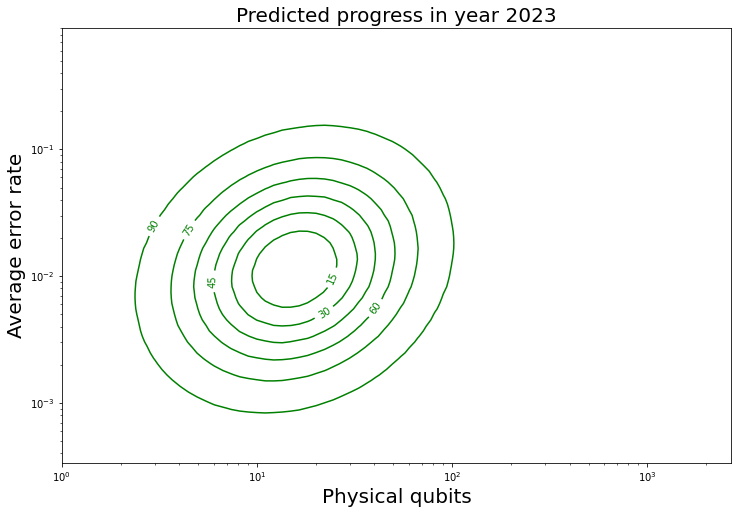

In [ ]:
#@title Multivariate linear regression {display-mode: "form"}
# Parameters
technology_filter = "Superconductor" #@param ["Superconductor", "all"]
threshold_year = 2000 #@param {type: "slider", min: 2000, max: 2020}
threshold_year = pd.Timestamp(year=threshold_year, month=1, day=1)

# Mask invalid values
mask  = df["Date"] >= threshold_year
mask &= ~np.isnan(df["Date"])
mask &= ~np.isnan(df["Physical qubits"])
mask &= ~np.isnan(df["Average two-qubit gate error rate"])
if technology_filter != "all":
  mask &= df["Technology"] == technology_filter
df_temp = df[mask]

# Constructor predictor and response variables
x = df_temp["Date"].apply(lambda x: x.year + x.month/12).values.reshape((-1,1))
X = np.c_[np.ones((x.shape[0], 1)), x]
y1 = np.log(df_temp["Physical qubits"].values)
y2 = np.log(df_temp["Average two-qubit gate error rate"].values)
Y = np.c_[y1,y2]
print(f"The number of data points we are using is {X.shape[0]}")
print(f"")

# Compute estimators
B_hat = np.linalg.solve(np.matmul(X.T, X),np.matmul(X.T, Y))
print(f"B_hat.shape = {B_hat.shape}")
error = Y-np.matmul(X, B_hat)
Sigma_hat = np.matmul(error.T, error) / (X.shape[0] - X.shape[1])
print(f"Sigma_hat.shape = {Sigma_hat.shape}")
print("")

print("B_hat")
print(B_hat)
print("")

print("Sigma_hat")
print(Sigma_hat)
print("")



# Display some intuitive characteristics
sample_year = 2020

print(f"The estimated physical qubit drift is {B_hat[1,0]}")
print(f"The estimated doubling time is {np.log(2)/B_hat[1,0]} years")
print(f"The median value by {sample_year} is {np.exp(B_hat[0,0] + sample_year*B_hat[1,0])} physical qubits")
print("")

print(f"The estimated error rate drift is {B_hat[1,1]}")
print(f"The estimated halving time is {-np.log(2)/B_hat[1,1]} years")
print(f"The median value by {sample_year} is {np.exp(B_hat[0,1] + sample_year*B_hat[1,1])} error rate")
print("")

# Build predictor
f = lambda t : np.matmul(np.c_[np.ones((t.shape[0],1)),t], B_hat)

# Sample some predictions
x_extrapolate_max = 2050 #previously x.max()
x_hat = np.linspace(x.min(), x_extrapolate_max, 1000)
y_hat = np.exp(f(x_hat))

# plot the results
prediction_year = 2023  #@param {type: "slider", min: 2000, max: 2100}

x, y = np.mgrid[0:8:0.1, -8:0:0.1]
pos = np.dstack((x, y))
mean = f(np.array([prediction_year])).flatten()
rv = multivariate_normal(mean, cov= Sigma_hat)
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111)
ax2.set_title(f"Predicted progress in year {prediction_year}", fontsize=20)
ax2.set_xlabel("Physical qubits", fontsize=20)
ax2.set_ylabel("Average error rate", fontsize=20)
ax2.set_xscale("log")
ax2.set_yscale("log")

heatmap = rv.pdf(pos)

def quantiles_func(pos):
  mask = heatmap > rv.pdf(pos)
  integral = np.sum(heatmap[mask]) * (0.1*0.1) # approximate integral
  return integral

quantiles = np.array([[quantiles_func(x_y) for x_y in row] for row in pos])
assert quantiles.shape == heatmap.shape
assert (quantiles <= 1.).all(), f"np.max(quantiles) = {np.max(quantiles)}"

CS2 = ax2.contour(np.exp(x), np.exp(y), quantiles*100, colors='green');
ax2.clabel(CS2, inline=1, fontsize=10, fmt="%1i");

median = np.exp(mean)
print(f"Predicted median of physical qubits = {median[0]}")
print(f"Predicted median of average error rate = {median[1]}")

In [ ]:
#@title Multivariate covariance estimation with bootstrapping {run: "auto", display-mode: "form"}
# Parameters
technology_filter = "Superconductor" #@param ["Superconductor", "all"]
threshold_year = 2003 #@param {type: "slider", min: 2000, max: 2020}
B = 1000 #@param 
seed = 111 #@param {type:"number"}
np.random.seed(seed)

# Mask invalid values
mask  = df["Date"] >= pd.Timestamp(year=threshold_year, month=1, day=1)
mask &= ~np.isnan(df["Date"])
mask &= ~np.isnan(df["Physical qubits"])
mask &= ~np.isnan(df["Average two-qubit gate error rate"])
if technology_filter != "all":
  mask &= df["Technology"] == technology_filter
df_temp = df[mask]

n = len(df_temp)
print(f"The number of data points we are using is {n}")
print(f"")

covariance_samples = np.zeros(B)

for subsample_idx in range(B):
  subsample_df = df_temp.sample(n, replace=True) 

  # Constructor predictor and response variables
  x = subsample_df["Date"].apply(lambda x: x.year + x.month/12).values.reshape((-1,1))
  X = np.c_[np.ones((x.shape[0], 1)), x]
  y1 = np.log(subsample_df["Physical qubits"].values)
  y2 = np.log(subsample_df["Average two-qubit gate error rate"].values)
  assert X.shape[0] == n
  Y = np.c_[y1,y2]

  # Compute estimators
  B_hat = np.linalg.solve(np.matmul(X.T, X),np.matmul(X.T, Y))
  error = Y-np.matmul(X, B_hat)
  Sigma_hat = np.matmul(error.T, error) / (X.shape[0] - X.shape[1])

  covariance_samples[subsample_idx] = Sigma_hat[0,1]

sorted_covariance_samples = np.sort(covariance_samples)
critical_idx = np.argmax(sorted_covariance_samples > 0.)
critical_quantile = critical_idx / len(sorted_covariance_samples)
print(f"The covariance is positive with confidence {1-critical_quantile}")


lower_bound = np.quantile(sorted_covariance_samples, 0.05)
upper_bound = np.quantile(sorted_covariance_samples, 0.95)
print(f"The 90% confidence interval is {lower_bound, upper_bound}")

The number of data points we are using is 31

The covariance is positive with confidence 0.845
The 90% confidence interval is (-0.11448254794431596, 0.47693725839755213)


# Geometric drift model

We fit the data we collected to the geometric drift model from [(Farmer and Lafond, 2016)](https://www.sciencedirect.com/science/article/pii/S0048733315001699)

We model progress as a random walk in log-space with some drift and noise autocorrelation ie $y_t = y_{t-1} + \mu + \nu_t + \theta \nu_{t-1}$, where $y_t$ are the log values of the metric of interest and $\nu_t \sim \mathcal{N}(0, \sigma^2)$.

We can estimate the parameters of this model as

$${\oversetˆ\mu}_{t_0}=\frac1m\sum_{i=t_0-m}^{t_0-1}(y_{i+1}-y_i)=\frac{y_{t_0}-y_{t_0-m}}m,$$

$$\oversetˆK_{t_0}^2=\frac1{m-1}\sum_{i=t_0-m}^{t_0-1}{\lbrack(y_{i+1}-y_i)-{\oversetˆ\mu}_{t_0}\rbrack}^2,$$

$$A^\ast=-2\theta+\left(1+\frac{2(m-1)\theta}m+\theta^2\right)\left(\tau+\frac{\tau^2}m\right),$$

The forecast for $\tau$ years after our final data point $y_t$ is distributed as

$$y_S(t+\tau)\sim\mathcal N(y_S(t)+{\widetilde\mu}_S\tau,\widetilde K_S^2A^\ast/(1+\theta_m^2)).$$

Date of analysis : 2020-08-12 09:19:31.905629
n = 10
μ=0.7535981217687973
K2=0.8019856520680307
θ=0.63
m=5
estimated doubling time = 0.9197835829699715 years

SHAPHIRO-WILK TEST
W=0.859576940536499
p-value=0.22673337161540985

The quantity of GLQs will exceed 1 by the year 2024.888888888889 with probability 15%
The quantity of GLQs will exceed 1 by the year 2028.948948948949 with probability 50%
The quantity of GLQs will exceed 1 by the year 2055.7297297297296 with probability 85%

The quantity of GLQs will exceed 4100 by the year 2031.1351351351352 with probability 15%
The quantity of GLQs will exceed 4100 by the year 2039.957957957958 with probability 50%
The quantity of GLQs will exceed 4100 by the year 2095.705705705706 with probability 85%



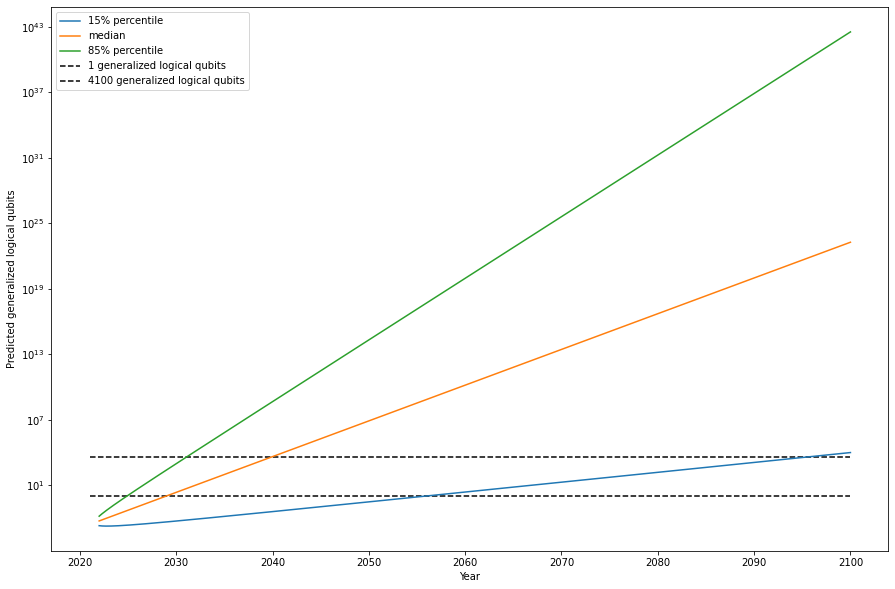

In [ ]:
#@title Geometric drift model {display-mode: "form", run: "auto"}
print(f"Date of analysis : {datetime.now()}")
# specify target
target = "Generalized logical qubits" #@param ["Physical qubits", "Average two-qubit gate error rate", "Generalized logical qubits"]
time_horizon = (2015, 2021)           #@param
#time_horizon = [pd.Timestamp(year=x, month=1, day=1) for x in time_horizon]
prediction_horizon = 2100             #@param {type:"number"}
thresholds = [1,4100]                 #@param

# Filter data
df_hat = df.dropna(subset=["Year", target])
df_hat = df_hat[df_hat[target] > 0.]
df_hat = df_hat[df_hat["Year"] > time_horizon[0]]
df_hat = df_hat[df_hat["Year"] < time_horizon[1]]

print(f"n = {len(df_hat)}")

## aggregate maximum data
# Temporarily flip the fidelity so the code is equal to the other metrics (max instead of min)
if target == "Average two-qubit gate error rate":
  df_hat[target] = -df_hat[target].values

# create new dataframe aggregating max metrics so far
l = []
for year in range(math.floor(df["Year"].min()), math.ceil(df["Year"].max())):
  row = {"Year": year}
  mask = df["Year"] <= year
  df_temp = df[mask]
  row[target] = df_temp[target].max()
  l.append(row)

df_hat = pd.DataFrame(l)
df_hat = df_hat[df_hat[target] > 0.]

# Undo flipping
if target == "Average two-qubit gate error rate":
  df_hat[target] = -df_hat[target].values

# prepare data
logseries = np.log(df_hat[target])
logdeltas = logseries.diff().iloc[1:]

# model parameter fitting
m = len(logdeltas)   # number of deltas
θ = 0.63             # autocorrelation parameter
μ = logdeltas.mean() # estimated mean
K2 = logdeltas.var() # estimated variance

print(f"μ={μ}")
print(f"K2={K2}")
print(f"θ={θ}")
print(f"m={m}")
print(f"estimated doubling time = {np.log(2)/μ} years")
print(f"")

# Shaphiro-Wilk test
W,p = stats.shapiro(logdeltas)

print(f"SHAPHIRO-WILK TEST")
print(f"W={W}")
print(f"p-value={p}")
print("")

# prediction functions
y_0 = logseries.iloc[-1]
t_0 = time_horizon[1]

A_star_t = lambda t : -2*θ+(1+(2*(m-1)*θ)/m+θ**2)*((t-t_0)+(t-t_0)**2/m)
μ_t = lambda t : y_0 + μ*(t-t_0)
σ2_t = lambda t : K2*A_star_t(t)/(1+θ**2)

quantile = lambda F : np.vectorize(lambda t : np.exp(μ_t(t)+np.sqrt(2*σ2_t(t))*special.erfinv(2*F-1)))

# predictions
time_range = np.linspace(t_0+1, prediction_horizon, 1000)
percentile_15_pred = quantile(0.15)(time_range)
median_pred = quantile(0.5)(time_range)
percentile_85_pred = quantile(0.85)(time_range)

# Find threshold crossings
for threshold in thresholds:
  if np.any(percentile_85_pred > threshold):
    percentile_15_threshold = time_range[np.min(np.argwhere(percentile_85_pred > threshold))]
    print(f"The quantity of GLQs will exceed {threshold} by the year {percentile_15_threshold} with probability 15%")

  if np.any(median_pred > threshold):
    median_threshold = time_range[np.min(np.argwhere(median_pred > threshold))]
    print(f"The quantity of GLQs will exceed {threshold} by the year {median_threshold} with probability 50%")
  
  if np.any(percentile_15_pred > threshold):
    percentile_85_threshold = time_range[np.min(np.argwhere(percentile_15_pred > threshold))]
    print(f"The quantity of GLQs will exceed {threshold} by the year {percentile_85_threshold} with probability 85%")
  
  print("")

# prepare plot
fig = plt.figure(figsize=(15, 10));
ax = plt.axes();
ax.set_xlabel("Year");
ax.set_ylabel(f"Predicted {target.lower()}");
ax.set_yscale("log");

# plot predictions
line, = ax.plot(time_range,percentile_15_pred);
line.set_label("15% percentile");
line, = ax.plot(time_range, median_pred);
line.set_label("median");
line, = ax.plot(time_range,percentile_85_pred);
line.set_label("85% percentile");

# plot thresholds of interest
for threshold in thresholds:
  line = ax.hlines(threshold, t_0, prediction_horizon, linestyles='dashed')
  line.set_label(f"{threshold} {target.lower()}")

ax.legend();

In [ ]:
df_hat

,Year,Generalized logical qubits
12,2015,0.000060
13,2016,0.000523
14,2017,0.000635
15,2018,0.000635
16,2019,0.000860
17,2020,0.002585
